**Max Marks:** 75
<br>
**Due Date:** Mar 31 2021, 11:59 PM

# Submission Instructions
- Do not **plagiarize**. Institute plagiarism policy will be strictly followed.
- Remember to **turn in** after uploading on classroom.
- Kindly **document** the code.
- Your submission should be a single **notebook** file, **rollNo\_A2.ipynb** (rename the notebook and submit accordingly).
- **Late submission even by a minute will be considered void.**

# Importing Libraries

In [1]:
import numpy as np
import scipy.stats as ss
import math
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from itertools import product
import pandas as pd
from functools import reduce
from tabulate import tabulate

---
# Question 1 (25 Marks)

## Problem Statement

Use graph object from [networkx](https://networkx.org/) to define the following factor graph. Implement Sum-Product algorithm to pass messages across the graph and compute $P(A=a, B=b) \text{  } \forall a, b$ using the same.

<div align="center">
    <figure>
      <img src="https://drive.google.com/uc?export=view&id=1jFNCyNhsbUlLEmEoLEF7nGGzcsrpHGhX" style="width:550px;height:300px;">
      <figcaption>Figure 1: Factor Graph</figcaption>
    </figure>
</div>

All the random variables share same support i.e., $\in \{1, 2\}$.
The factors are defined as follows:
1. $f_1(a, b) = a * b$ $[$for example $f_1(2, 2) = 2 * 2 = 4]$
2. $f_2(b, c, d) = 2 * (5 - b*c) - d + 1$
3. $f_3(c) = 3 - c$
4. $f_4(d, e) = d * e$
5. $f_5(d) = 3 - d$

In [ ]:
# Function to create the above given factor graph
def Factor_Graph(factor_nodes,normal_nodes,edge,S):
  
  # Creatign the empty graph
  B = nx.Graph()

  # Adding nodes and edges to the graph
  B.add_nodes_from(factor_nodes + normal_nodes)
  B.add_edges_from(edge)
  
  # Adding factor to the factor nodes and the normal nodes
  for i in factor_nodes+normal_nodes:
    B.nodes[i]['factor'] = Factor(B,i,S)
    # print(Factor(B,i,S))

  print('\nCorresponding Factor Graph \n')
  plt.figure(figsize=(7,7))
  nx.draw(B,with_labels = True,node_size=1000, node_color='orange',edge_color='red',edgecolors='red') 
  plt.show() 

  return B  

# Function to define factor for each node
def Factor(B,node,S):
  n = len(list(B.neighbors(node)))
  factor_values = []
  if node[0] is 'f':
    t1 = [[i for i in range(1,S+1)] for i in range(n)]
    t2 = list(itertools.product(*t1))
    t3 = [list(t) for t in t2]
    Factor_df = pd.DataFrame(t3,columns = list(list(B.neighbors(node))))
    
    if node=='f1':
      factor_values = list( i*j for i,j in itertools.product(range(1,S+1), repeat=2))
    elif node=='f2':
      factor_values = list( 2*(5-i*j)-k+1 for i,j,k in itertools.product(range(1, S+1), repeat=3))
    elif node=='f3':
      factor_values = [ 3-i for i in range(1, S+1)]
    elif node=='f4':
      factor_values = list( i*j for i,j in itertools.product(range(1, S+1), repeat=2))
    elif node=='f5':
      factor_values = [ 3-i for i in range(1, S+1)]    
    Factor_df[node] = factor_values      
  else :
    Factor_df = [ 1 for i in range(1, 3)]
  return Factor_df

# Function to modify factor
def Clamp_Factor(B,node_clamp,clam_value,node):
  n = len(list(B.neighbors(node)))
  factor_values = []
  t1 = [[i for i in range(1,S+1)] for i in range(n)]
  t2 = list(itertools.product(*t1))
  t3 = [list(t) for t in t2]
  Factor_df = pd.DataFrame(t3,columns = list(list(B.neighbors(node))))
  if node_clamp=='a':
    factor_values = list( i*j*(i==clam_value) for i,j in itertools.product(range(1, 3), repeat=2))
  elif node_clamp=='b':
    factor_values = list( i*j*(j==clam_value) for i,j in itertools.product(range(1, 3), repeat=2))      
  
  Factor_df[node] = factor_values       
  return Factor_df

        
# Function to find the message from factor to node        
def factor_to_node(f,v,B,S):
  mu = []
  n = list(B.neighbors(f))
  if len(n)==1:
    P = nx.get_node_attributes(B,'factor')[f]
    mu = list(P[f])
    B.edges[(f,v)]['mu'] = np.array(mu)
  else:
    t = [g for g in n if g!=v]
    t.sort()
    M = []
    P = nx.get_node_attributes(B,'factor')[f]
    P1 = P.loc[P[v]==1]
    P2 = P.loc[P[v]==2]
    if t[0] in list(P.columns):
      P1 = P1.sort_values(t[0])
      P2 = P2.sort_values(t[0])
      P1 = np.array(P1[f])
      P2 = np.array(P2[f])
    for i in n:
      if i==v:
        continue
      else:
        M.append(np.array(B[f][i]['mu']))
    if len(n)>2:    
      Mumat = np.outer(M[0],M[1])
      Mumat_1 = np.multiply(P1,np.concatenate(Mumat))
      Mumat_2 = np.multiply(P2,np.concatenate(Mumat))
    else :
      Mumat = M[0]
      for i in range(1,len(M)):
        Mumat = np.multiply(Mumat,M[i])
      Mumat_1 = np.multiply(P1,Mumat)
      Mumat_2 = np.multiply(P2,Mumat)
    mu = [np.sum(Mumat_1),np.sum(Mumat_2)]
    B.edges[(f,v)]['mu'] = np.array(mu)

# Function to find the message from node to factor        
def node_to_factor(f,v,B,S):
  mu = []
  n = list(B.neighbors(v))
  if len(n)==1:
    mu = nx.get_node_attributes(B,'factor')[v]
    B.edges[(f,v)]['mu'] = np.array(mu)
  else:
    M = []
    for i in n:
      if i==f:
        continue
      else:
        M.append(np.array(B[i][v]['mu']))
    Mumat = M[0]
    for i in range(1,len(M)):
      Mumat = np.multiply(Mumat,M[i])
    mu = list(Mumat)
    B.edges[(f,v)]['mu'] = np.array(mu)

# Function for calculating the PMF : P(A=a,B=b) for all a and b    
def PMF(a,b,B,S):

  # Computing P(b)
  factor_to_node('f5','d',B,S)       #[ f5 to d]
  factor_to_node('f3','c',B,S)       #[ f3 to c] 
  node_to_factor('f4','e',B,S)       #[ e to f4]
  factor_to_node('f4','d',B,S)       #[ f4 to d]
  node_to_factor('f2','d',B,S)       #[ d to f4]
  node_to_factor('f2','c',B,S)       #[ c to f2]  
  factor_to_node('f2','b',B,S)       #[ f2 to b]
  node_to_factor('f1','b',B,S)       #[ b to f1]  
  node_to_factor('f1','a',B,S)       #[ a to f1]
  factor_to_node('f1','b',B,S)       #[ f1 to b] 
  pb = np.multiply(B['f1']['b']['mu'],B['f2']['b']['mu'])
  pb = pb/np.sum(pb)
  print('\nComputed Values : ')
  print('\nP(b) = ',pb)

  # Computing P(a/b=1)
  B.nodes['f1']['factor'] = Clamp_Factor(B,'b',1,'f1')
  node_to_factor('f1','b',B,S)
  factor_to_node('f1','a',B,S)
  pa_b1 = B['f1']['a']['mu']/np.sum(B['f1']['a']['mu'])
  print('\nP(a/b=1) = ',pa_b1)
  
  # Computing P(a,b=1)
  pab1 = pa_b1*pb[0]
  print('\nP(a,b=1) = ',pab1)

  # Computing P(a/b=2)
  B.nodes['f1']['factor'] = Clamp_Factor(B,'b',2,'f1')
  node_to_factor('f1','b',B,S)
  factor_to_node('f1','a',B,S)
  pa_b2 = B['f1']['a']['mu']/np.sum(B['f1']['a']['mu'])
  print('\nP(a/b=2) = ',pa_b2)
  
  # Computing P(a,b=2)
  pab2 = pa_b2*pb[1]
  print('\nP(a,b=2) = ',pab2)

  t1 = [[1,2] for i in range(2)]
  t2 = list(itertools.product(*t1))
  t3 = [list(t) for t in t2]

  pmf = pd.DataFrame(t3,columns = [a,b])
  pmf['PMF(A=a,B=b)'] = [0 for i in range(len(pmf))]

  temp = []
  for i in range(len(list(pmf.columns))-1):
    temp.append(round(pab1[i],5))
    temp.append(round(pab2[i],5))
    
  pmf['PMF(A=a,B=b)'] = temp
  
  return pmf


## Deliverables

Report/plot the pmf, $P(A, B)$ to indicate how the mass is distributed across different configurations.


Corresponding Factor Graph 



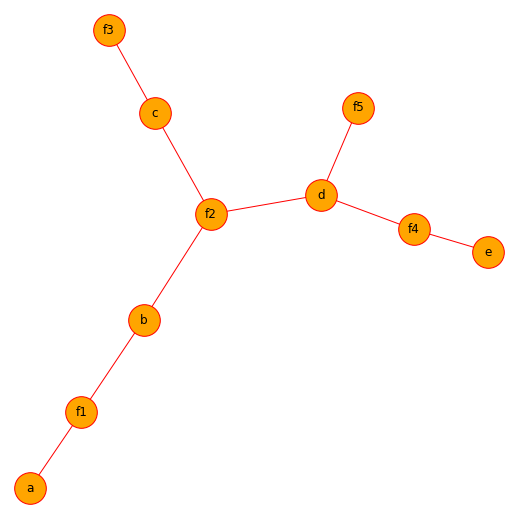


Computed Values : 

P(b) =  [0.45054945 0.54945055]

P(a/b=1) =  [0.33333333 0.66666667]

P(a,b=1) =  [0.15018315 0.3003663 ]

P(a/b=2) =  [0.33333333 0.66666667]

P(a,b=2) =  [0.18315018 0.36630037]

 +----+-----+-----+----------------+
|    |   a |   b |   PMF(A=a,B=b) |
|----+-----+-----+----------------|
|  0 |   1 |   1 |        0.15018 |
|  1 |   1 |   2 |        0.18315 |
|  2 |   2 |   1 |        0.30037 |
|  3 |   2 |   2 |        0.3663  |
+----+-----+-----+----------------+


In [ ]:
# Defining the factor nodes and the normal nodes
factor_nodes = ['f1', 'f2', 'f3', 'f4','f5']
normal_nodes = ['a','b','c','d','e']

# Support of each node 
S = 2

# Defining the edge set
edge = [('f1','a'),('f1','b'),('f2','b'),('f2','c'),('f2','d'),('f3','c'),('f4','d'),('f4','e'),('f5','d')]

# Creating the factor graph using Factor_Graph function
B = Factor_Graph(factor_nodes,normal_nodes,edge,S)

# Calling the PMF function
pmf = PMF('a','b',B,S)
print('\n',tabulate(pmf, headers='keys', tablefmt='psql'))

---
# Question 2 (20 Marks)
## Problem Statement
Assume that you want to have samples from univariate distribution, $p = \mathcal{N}(0, 1)$. Use the univariate proposal, $q = \mathcal{N}(0, \sigma^{2})$ and implement Metropolis-Hastings algorithm to sample from $p$. 

Note: Use *random seed 42* to reproduce results.

In [2]:
np.random.seed(42)
def MHastings(init, iters, step_sizes):
    '''
    Parameters
    ----------
    init : int
        The initial state from where you will start proposing with respect to q
    iters: intiter
        Numbers of samples you want to have from p at the end of routine
    step_sizes : list
        List of sigma values with respect to q that you want to try upon to compare across them
        
    Returns
    -------
    tuple
         1st argument -- Samples you got for each step_size (list of lists)  
         2nd argument -- ratio of samples accepted per step_size (list)
    '''

    # List of samples that will be sampled
    final_samples = []

    # List for ratio of samples accepted per step_size (list)
    ratio = []
    
    # Iterating over each step_sizes
    for i in range(len(step_sizes)):
      sigma = step_sizes[i]

      # Given distrubution 
      px = ss.norm(0,1)
      k , j = 0 , 0
      samples = []
      theta = init

      # Loop until iters number of samples collected
      for j in range(iters):
        
        # Generating the new theta value from the old theta value
        newtheta = np.random.normal(theta,sigma,1)[0]
        p1 = ss.norm(newtheta,sigma).pdf(theta)*px.pdf(newtheta)
        p2 = ss.norm(theta,sigma).pdf(newtheta)*px.pdf(theta)

        # Acceptance ratio
        alpha = p1/p2

        # Condition to either accept or reject the sample
        if (alpha>=1):
          samples.append(newtheta)
          theta = newtheta
        elif (alpha>0 and alpha<1):
          U = np.random.uniform(0,1,1)
          if U < alpha :
            samples.append(newtheta)
            theta = newtheta           
            
      final_samples.append(samples)
      ratio.append(len(samples)/iters)

    return (final_samples,ratio)  
 



## Deliverables

1. Use **init=0, iters=1000, step_sizes = [0.1, 1, 100]** and run the MHastings routine.
2. Plot the retrieved samples $-$ your plot should have a subplot for each of the above mentioned step_size
3. Write inferences that you can draw from the final plot.

In [4]:
# Defining the parameter values
init=0
iters=1000
step_sizes = [ 1 ]
for i in [100,1000,10000]:
  (final_samples,ratio)  = MHastings(init,i, step_sizes)
  print('Averge with n = ',i,' : ',np.mean(np.array(final_samples[0])))

Averge with n =  100  :  0.1868113071258813
Averge with n =  1000  :  0.0012179913547876238
Averge with n =  10000  :  0.019829085760003154


In [ ]:
# Defining the parameter values
init=0
iters=1000
step_sizes = [ 0.1 , 1, 100]

In [ ]:
# Running MHasting function
np.random.seed(42)
(final_samples,ratio)  = MHastings(init, iters, step_sizes)

				Statistics 
+----+--------------+------------+----------------------+-----------------------------+
|    |   Step Sizes |       Mean |   Standard Deviation |   Ratio of Samples Accepted |
|----+--------------+------------+----------------------+-----------------------------|
|  0 |          0.1 |  0.819921  |             0.694443 |                       0.965 |
|  1 |          1   |  0.0329027 |             0.992526 |                       0.686 |
|  2 |        100   | -0.194995  |             1.64192  |                       0.013 |
+----+--------------+------------+----------------------+-----------------------------+


						Required Plots



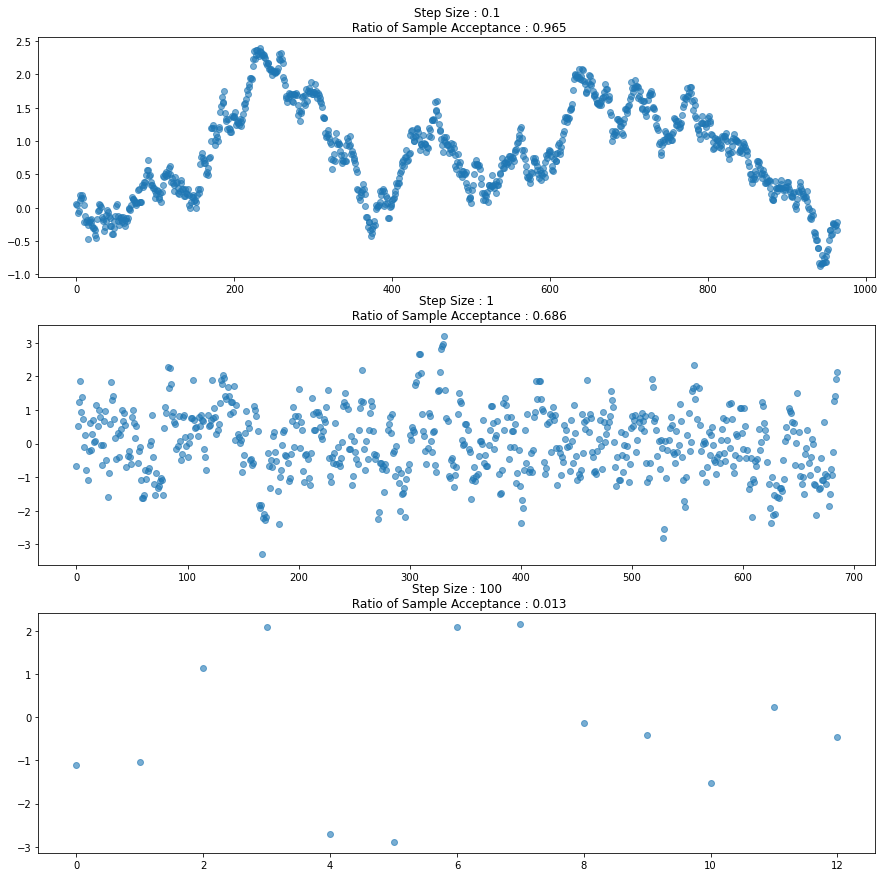

In [ ]:
# Priting the statistics in tabular form and plotting the sampled values

mean = []
std = []
for i in range(len(step_sizes)):
  mean.append(np.mean(np.array(final_samples[i])))
  std.append(np.std(np.array(final_samples[i])))

Results = pd.DataFrame()
Results['Step Sizes'] = step_sizes
Results['Mean'] = mean
Results['Standard Deviation'] = std
Results['Ratio of Samples Accepted'] = ratio

print('\t\t\t\tStatistics ')
print(tabulate(Results, headers='keys', tablefmt='psql'))

print('\n\n\t\t\t\t\t\tRequired Plots\n')
fig, ax = plt.subplots(ncols=1, nrows=len(step_sizes),figsize=(15,15))
for i in range(len(step_sizes)):
  ax[i].scatter(range(len(final_samples[i])),final_samples[i],alpha=0.6)
  ax[i].set_title('Step Size : '+str(step_sizes[i])+'\n Ratio of Sample Acceptance : '+str(ratio[i]))
plt.show()


## Inference From the Final Plots


---


1. When the step size $(i.e. 1)$ is equal to the actual standard derivation of the distribution, then the standard empirical derivation of the sampled points is close to the actual standard derivation.
2. When the step size is small $(i.e. 0.1)$ , then the acceptance ratio is high .From the Statistics table , $686$ points are sampled form the $1000$ iterations.This is clear from plot 1.
3. When the step size is increased from $0.1$ , the acceptance ratio starts decreasing at a higher rate.
4. For a step size of $100$ , the acceptance ratio is $0.013$ , which is significantly less as compared to the acceptance ratio with a step size of $0.1$ .


---
# Question 3 (20 Marks)

## Problem Statement
Assume want to have samples from bivariate distribution, $p = \mathcal{N}(\mathbf{\mu}, \Sigma)$ where $\mathbf{\mu} \in \mathbb{R}^2, \Sigma \in \mathbb{R}^{2 \times 2}$. Implement Gibbs sampling to sample from $p$.

Note: Use *random seed 42* to reproduce results.

## Approach 

<div align="center">
    <figure>
      <img src="https://miro.medium.com/max/1130/1*uenaoaVdM2V7Cf-PUv-UdQ.png" style="width:550px;height:300px;">
    </figure>
</div>


In [ ]:
np.random.seed(42)
def Gibbs(init, iters, mu, sigma):
    '''
    Parameters
    ----------
    init : int
        The initial state from where you will start proposing
    iters: int
        Numbers of samples you want to have from p at the end of routine
    mu : list
        Mean vector of the bivariate normal
    sigma : list of lists
        Covariance matrix of the bivariate normal
        
    Returns
    -------
    list
         samples you got at the end of this routine
    '''

    samples = [init]
    x0 = 5
    y0 = 7

    s1 = sigma[0][0]**0.5
    s2 = sigma[1][1]**0.5
    s12 = sigma[0][1]
    
    cor = (s12/(s1*s2))

    # Iterating till iters number of samples are generated
    for i in range(1,iters):

      # Calculating the mean and sigma value for the distribution P(X/Y=y)
      xm = mu[0] + cor*(s1/s2)*(y0-mu[1])
      xs = s1*(1-(cor**2))**0.5

      # Generating the sample x1 for (x1,y1)
      x1 = np.random.normal(xm,xs,1)[0]

      # Calculating the mean and sigma value for the distribution P(Y/X=x)
      ym = mu[1] + cor*(s2/s1)*(x1-mu[0])
      ys = s2*(1-(cor**2))**0.5

      # Generating the sample y1 for (x1,y1)
      y1 = np.random.normal(ym,ys,1)[0]

      # Integrating whole sample
      samples.append([x1,y1])

      x0 , y0 = x1 , y1

    return samples  

## Deliverables

1. Attach drive link to document (*give permissions to me so that I can view the same*) in which you need to prove that both the conditionals are indeed univariate normals but with different means and variances.
   - Link to view document :  https://drive.google.com/file/d/1-B51oc9zVYVoMzviTPPqWDhmxyHVfTN0/view?usp=sharing
2. Use **init=[5, 7], iters=500, mu = [0, 0], sigma = [[5, 3], [3, 2]]** and run the Gibbs routine.
3. Use the retrieved samples to approximate $\mathbb{E}[X]$ and $\mathbb{E}[X^2+3X]$.

In [ ]:
# Defining the parameter values
init=[5, 7]
iters=500
mu = [0,0]
sigma = [[5, 3], [3, 2]]

In [ ]:
# Running Gibbs function
np.random.seed(42)
samples = Gibbs(init, iters, mu, sigma)
print('Samples : ',samples)


Samples :  [[5, 7], [10.851229945905573, 6.448904292287288], [10.131341395818731, 6.759924495629257], [9.974315304339298, 5.879879952246916], [9.93649201915235, 6.305102456027419], [9.12568516215313, 5.718051325158571], [8.24939119462834, 4.741354039151539], [7.283124221742951, 3.514229595633317], [4.051643297090408, 2.1795233505976013], [2.553105272511162, 1.6723988429929009], [1.8665282832076566, 0.4883155537125391], [1.768843513910955, 0.9603358772273103], [1.4882534672971495, 0.25578532133972576], [-0.0012587340629764965, 0.048850849728529974], [-0.7405990891046792, -0.2763421918562303], [-0.8392289784689366, -0.6339867977112785], [-1.3764510223591089, 0.00249337334491162], [-0.00580391912202447, -0.4765050590111837], [-0.1331305033381175, -0.6258561802497037], [-0.7910954060036921, -1.3510483656963381], [-2.9657419103979548, -1.6914061251311767], [-2.0149344613023716, -1.1323224515958084], [-1.7802593621030138, -1.202813283584619], [-2.849692850899168, -2.0317398271755196], [-3.37

In [ ]:
c = np.array(samples)
c = c.T
print('Covariance matrix of sampled points : ')
print(np.cov(c))

Covariance matrix of sampled points : 
[[5.73791031 3.47814245]
 [3.47814245 2.33656398]]


In [ ]:
# Finding E[X]
Sample = np.array(samples)
print('E[X] : ',np.mean(Sample,axis=0))

# Finding E[X^2 + 3X]
NewSample = (np.power(Sample,2)) + (3*Sample)
print('E[X^2 + 3X] : ',np.mean(NewSample,axis=0))


E[X] :  [0.49963079 0.32294695]
E[X^2 + 3X] :  [7.4749578  3.40502645]


---
# Question 4 (10 Marks)
## Problem Statement
Assume you have a $D \times N$ data matrix that contains a multivariate datapoint on each column. Implement a Chow-Liu routine that returns a *maximum likelihood tree* in the form of a sparse matrix

## Formula used for calculating the Mutual Information

<div align="center">
    <figure>
      <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/7f3385f4d779f062696c134223b5683e754a6f1c" style="width:550px;height:300px;">
    </figure>
</div>


In [ ]:
def Chow_Liu_Tree(Data):

  # Defining matrix to hold the mutual information between each pair of nodes
  I = np.zeros((Data.shape[0],Data.shape[0]))
  m = Data.shape[1]

  # Iterating over matrix
  for i in range(I.shape[0]):
    for j in range(I.shape[0]):
      s = 0

      # Getting the values for ith and jth column
      xiu = list(set(Data[i]))
      xju = list(set(Data[j]))
      for k in range(len(xiu)):
        for l in range(len(xju)):
          dxi = list(Data[i])
          dxj = list(Data[j])
          Pxi = dxi.count(xiu[k])/m
          Pxj = dxj.count(xju[l])/m
          Pxij = 0
          for n in range(len(dxi)):
            if dxi[n] == xiu[k] and dxj[n] == xju[l]:
              Pxij = Pxij + 1
          Pxij =  Pxij/m

          if Pxij==0:
            continue
          s = s + (Pxij*math.log((Pxij)/(Pxi*Pxj)))

      I[i,j] = s    
  
  # Generating Graph based on Mutual Information matrix
  print('\nMutual Information\n',I)
  print('\nInitial Graph with list of node labels : ',[i for i in range(Data.shape[0])])
  Graph = nx.from_numpy_matrix(I)
  plt.figure(figsize=(10,10))
  nx.draw_spectral(Graph, with_labels=True, node_size=1000, node_color='orange',edge_color='red',edgecolors='red')
  plt.show()

  # Finding the maximum cost spanning tree
  print('\nMaximum Cost Spanning Tree\n')
  MST = nx.maximum_spanning_tree(Graph)
  plt.figure(figsize=(10,10))
  nx.draw_spectral(MST, with_labels=True,node_size=1000, node_color='orange',edge_color='red',edgecolors='red')
  plt.show()

  # Get choice for the first variable node
  initial = int(input('Enter the choice of first variable between 0 and '+str(Data.shape[0]-1)+' : '))
  print('\nInitial Node :',initial)
  print('\nFinal DAG\n')
  plt.figure(figsize=(10,10))
  DAG = nx.dfs_tree(MST, source=initial)
  nx.draw_spectral(DAG, with_labels=True, node_size=1000, node_color='orange',edge_color='red',edgecolors='red',width=3)
  plt.show()

  # Finding the final sparse matrix
  Sparse = nx.to_numpy_matrix(DAG, nodelist=[i for i in range(len(Graph))])
  Sparse = Sparse.astype('int')
  
  return np.multiply(Sparse,I),DAG


## Deliverables

1. Simulate the routine for a reasonable data matrix of your choice and print the sparse matrix. 
2. Also draw the resulting DAG with edges oriented away from *first variable* $-$ you can draw the DAG via:
     - Writing code (or)
     - add it in the above document (*of question 3*) (or) in a new document
        - -- *edit and add document link here* --


Shape of Data taken :  (6, 500)

Mutual Information
 [[1.73077446 0.04426822 0.04395232 0.04518808 0.06247749 0.04204665]
 [0.04426822 1.69025644 0.04958321 0.05552321 0.06129945 0.05252188]
 [0.04395232 0.04958321 1.72093702 0.04513499 0.02875503 0.03688703]
 [0.04518808 0.05552321 0.04513499 1.7037017  0.04797435 0.02973739]
 [0.06247749 0.06129945 0.02875503 0.04797435 1.68889461 0.05488579]
 [0.04204665 0.05252188 0.03688703 0.02973739 0.05488579 1.70947107]]

Initial Graph with list of node labels :  [0, 1, 2, 3, 4, 5]


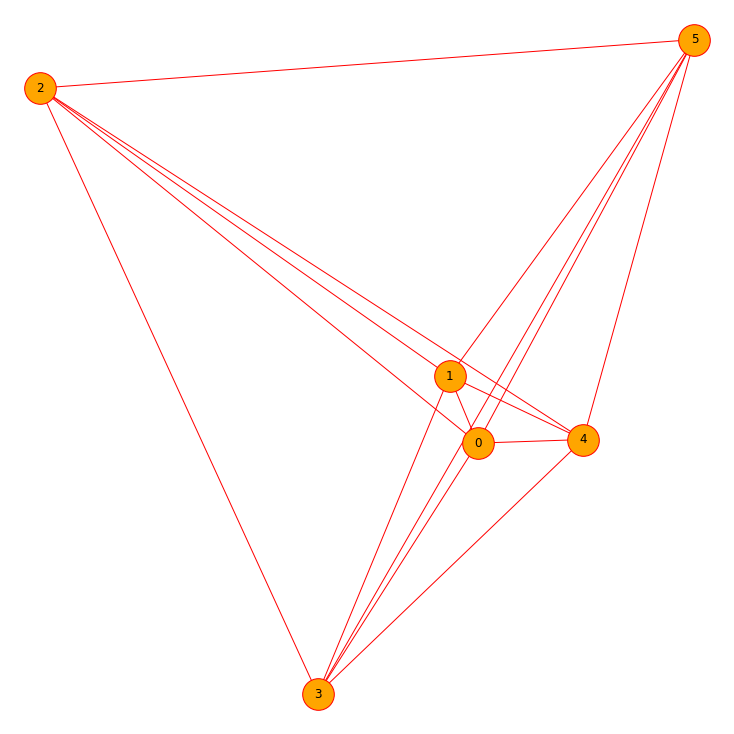


Maximum Cost Spanning Tree



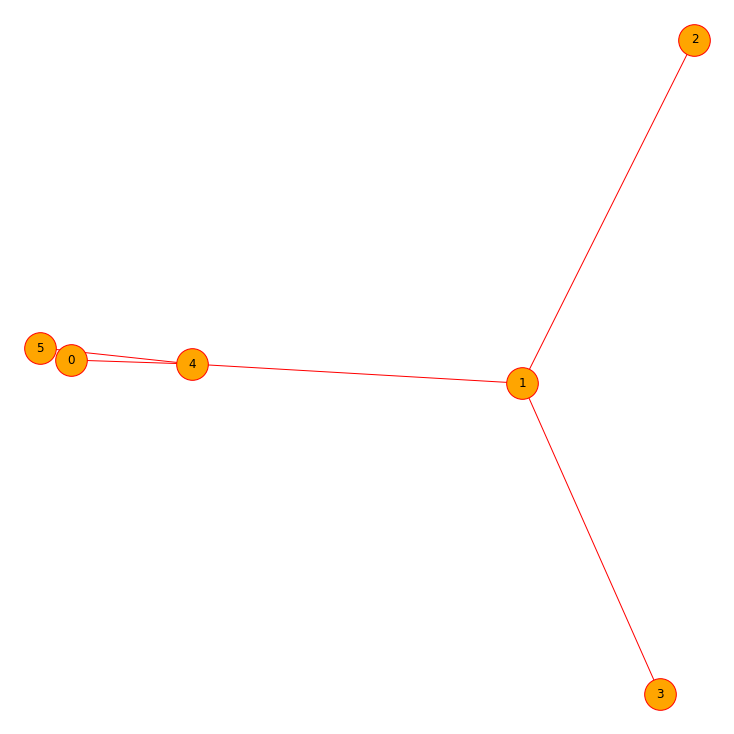

Enter the choice of first variable between 0 and 5 : 1

Initial Node : 1

Final DAG



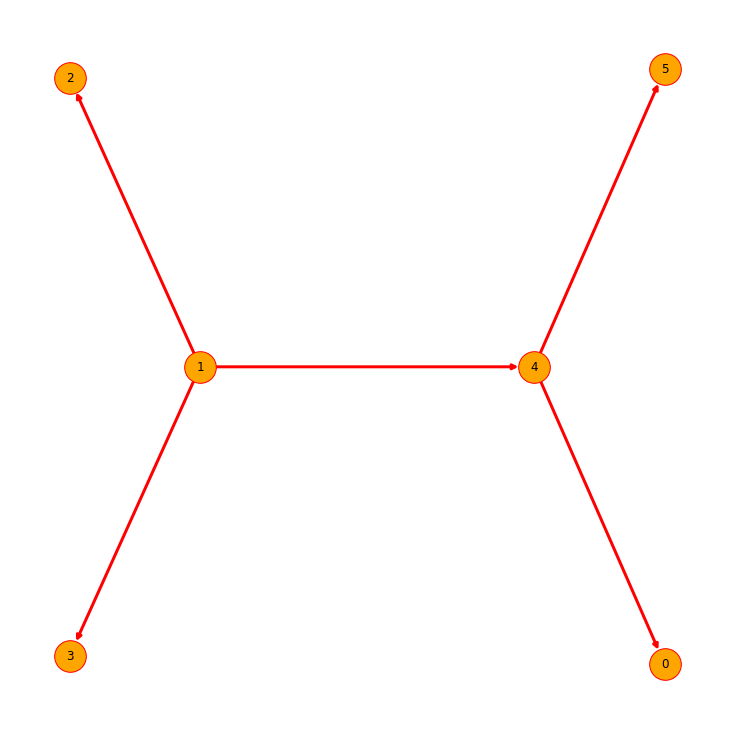


Final Sparse Matrix : 
 [[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.04958321 0.05552321 0.06129945 0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.06247749 0.         0.         0.         0.         0.05488579]
 [0.         0.         0.         0.         0.         0.        ]]


In [ ]:
np.random.seed(42)

# Generating the random multinomial data
Data = np.random.multinomial(1000, [1/500.]*500, size=6)
print('\nShape of Data taken : ',Data.shape)

# Calling the Chow_Liu_Tree function
Sparse , DAG = Chow_Liu_Tree(Data)  
print('\nFinal Sparse Matrix : \n',Sparse)